# Imports

In [1]:
import airr
import json
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

/Users/s236922/code/apps/miniconda3/envs/xplor/lib/python3.13/site-packages/airr/schema.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream


# Data

In [2]:
subject_md = pd.read_csv('./subject_metadata_COVVAX.tsv', delimiter='\t')
sample_md = pd.read_csv('./sample_processing_metadata_COVVAX.tsv', delimiter='\t')
repertoires = airr.read_airr('./repertoires.airr.json')

# Exploratory analysis

In [3]:
sample_counts = sample_md.groupby('subject_id').size()
print('Breakdown of # samples per subject ID:')
print(sample_counts.value_counts())
print()

samp_multi_subj_id = [str(e) for e in sample_counts[sample_counts > 1].index.to_list()]
samp_1_subj_id = [str(e) for e in sample_counts[sample_counts == 1].index.to_list()]
samp_2_subj_id = [str(e) for e in sample_counts[sample_counts == 2].index.to_list()]
samp_3_subj_id = [str(e) for e in sample_counts[sample_counts == 3].index.to_list()]
samp_4_subj_id = [str(e) for e in sample_counts[sample_counts == 4].index.to_list()]


Breakdown of # samples per subject ID:
1    96
2    24
3     7
4     3
Name: count, dtype: int64



In [4]:
sample_md[sample_md['subject_id']==283].columns

Index(['repertoire_id', 'subject_id', 'sample_processing_id', 'sample_id',
       'sample_type', 'tissue', 'anatomic_site', 'disease_state_sample',
       'collection_time_point_relative', 'collection_time_point_relative_unit',
       'collection_time_point_reference', 'biomaterial_provider',
       'tissue_processing', 'cell_subset', 'cell_phenotype', 'cell_species',
       'single_cell', 'cell_number', 'cells_per_reaction', 'cell_storage',
       'cell_quality', 'cell_isolation', 'cell_processing_protocol',
       'template_class', 'template_quality', 'template_amount',
       'template_amount_unit', 'library_generation_method',
       'library_generation_protocol', 'library_generation_kit_version',
       'complete_sequences', 'physical_linkage', 'sequencing_run_id',
       'total_reads_passing_qc_filter', 'sequencing_platform',
       'sequencing_facility', 'sequencing_run_date', 'sequencing_kit',
       'pcr_target.0.pcr_target_locus',
       'pcr_target.0.forward_pcr_primer_targe

In [5]:
subject_md.columns

Index(['vdjserver_uuid', 'subject_id', 'synthetic', 'species', 'sex',
       'age_min', 'age_max', 'age_unit', 'age_event', 'ancestry_population',
       'ethnicity', 'race', 'strain_name', 'linked_subjects', 'link_type',
       'diagnosis.0.study_group_description', 'diagnosis.0.disease_diagnosis',
       'diagnosis.0.disease_length', 'diagnosis.0.disease_stage',
       'diagnosis.0.prior_therapies', 'diagnosis.0.immunogen',
       'diagnosis.0.intervention', 'diagnosis.0.medical_history'],
      dtype='object')

In [6]:
print(repertoires['Repertoire'][0]['subject']['subject_id'])
print(repertoires['Repertoire'][0]['sample'][0]['collection_time_point_reference'])

3192
1, 0-4 Weeks Before Vaccination


## graph view

In [30]:
def create_graph(repertoires, subj_IDs, pos=None, title='Connections Between Timepoints'):
    '''
    Parameters
    ----------
    repertoires : dict
        - give this data: airr.read_airr('repertoires.airr.json')
    subj_IDs : list
        - A list of subject IDs to plot between
    pos : dict
        - A dictionary for node positions (Default: None. Results in nx.circular_layout(G))
    title : str
        - Title for the graph (Default: Connections Between Timepoints)
    '''
    df = pd.DataFrame()

    for rep in repertoires['Repertoire']:
        if rep['subject']['subject_id'] in subj_IDs:
            new_df = pd.DataFrame({'id' : [rep['subject']['subject_id']], 
                                'timepoint' : [rep['sample'][0]['collection_time_point_reference']]})
            df = pd.concat([df, new_df], ignore_index=True)

    df = df.sort_values(by=['id', 'timepoint'], ignore_index=True)

    # ID with unique timepoint following current encounter
    connections = {}
    for i in range(len(df)-1):
        if df.loc[i, 'id'] != df.loc[i+1, 'id']:
            pass
        elif df.loc[i, 'timepoint'].split(', ')[0] == df.loc[i+1, 'timepoint'].split(', ')[0]:
            pass
        else:
            key = (df.loc[i, 'timepoint'], df.loc[i+1, 'timepoint'])
            if key not in connections:
                connections[key] = 1
            else:
                connections[key] += 1

    # Create graph visualization
    G = nx.Graph()
    times = df['timepoint'].unique()
    G.add_nodes_from(times)

    # add edges
    for (tp1, tp2), w in connections.items():
        G.add_edge(tp1, tp2, weight=w)

    # create layout if not defined
    if pos is None:
        # pos = {tp: (i, 0) for i, tp in enumerate(times)} # linear layout
        # pos = nx.spring_layout(G, seed=42)\
        pos = nx.circular_layout(G)
        print(pos)

    # node weight
    node_sizes = [df.groupby('timepoint')['id'].nunique().get(tp, 1) * 100 for tp in G.nodes()]

    # edge weight (use widths for normalization for max width)
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    # max_w = max(weights) if weights else 1
    # widths = [w / max_w * 10 for w in weights]

    plt.figure(figsize=(10, 6))
    edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.3)
    node_label_dict = df.groupby('timepoint')['id'].nunique().to_dict() # Get number of unique subject IDs per timepoint
    node_labels = {tp: f"{tp}\n(n={node_label_dict.get(tp, 1)})" for tp in G.nodes()} # Create label text that includes timepoint + count
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.3)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
    plt.title(title)
    plt.axis('off')
    plt.show()

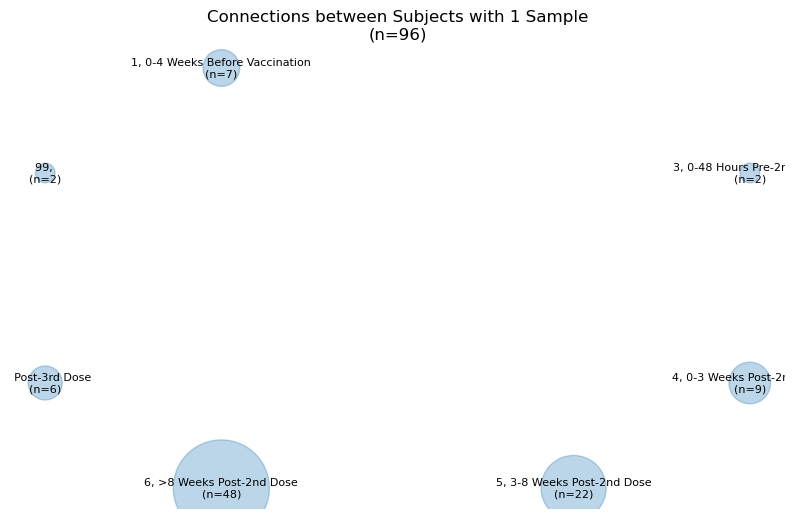

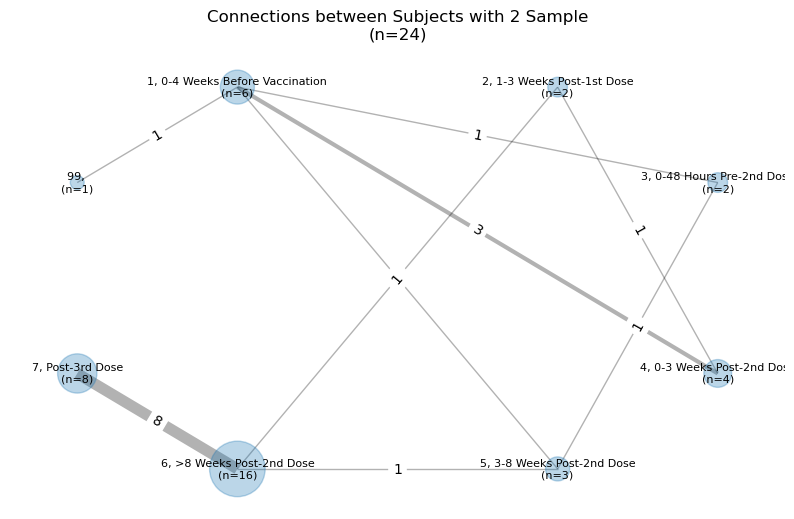

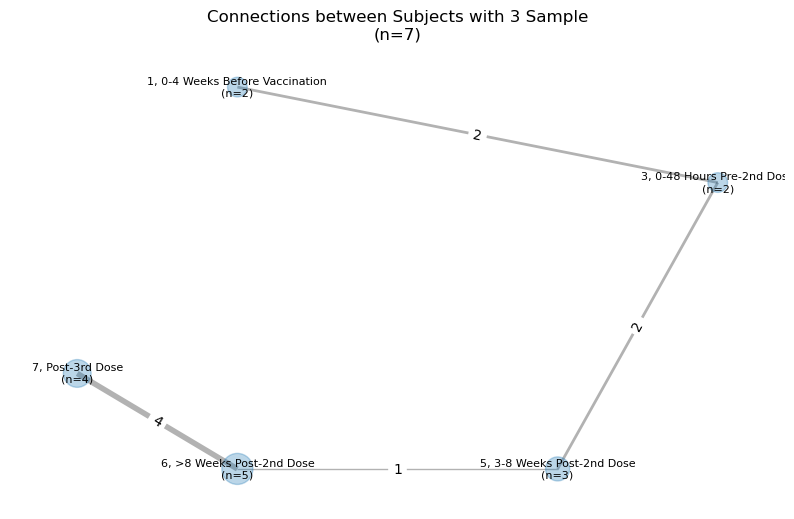

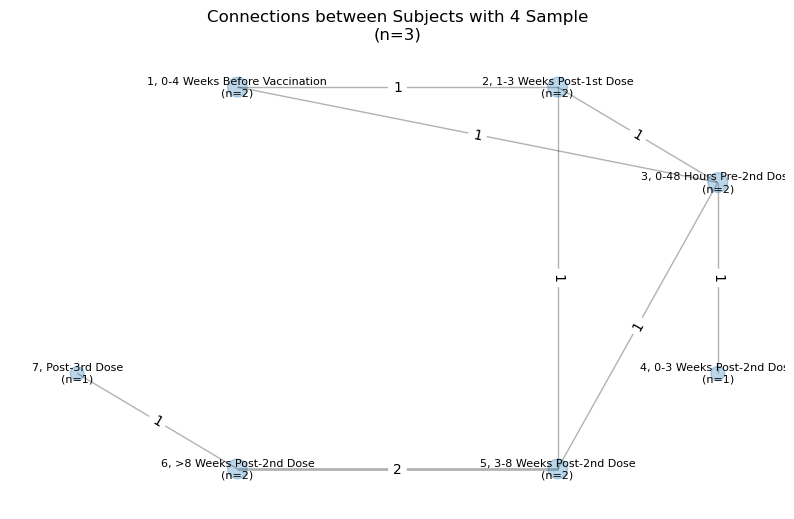

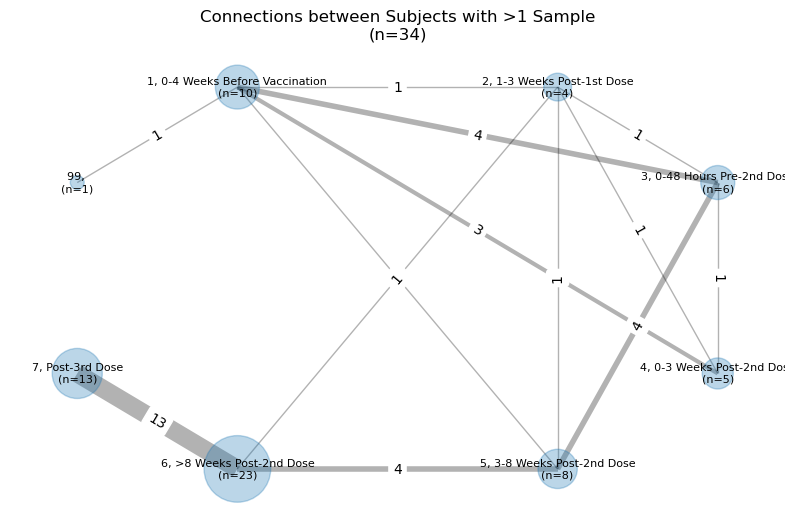

In [31]:
pos = {
    '1, 0-4 Weeks Before Vaccination'   : np.array([-0.5,  1.0]),
    '2, 1-3 Weeks Post-1st Dose'        : np.array([ 0.5,  1.0]),
    '3, 0-48 Hours Pre-2nd Dose'        : np.array([ 1.0,  0.5]),
    '4, 0-3 Weeks Post-2nd Dose'        : np.array([ 1.0, -0.5]),
    '5, 3-8 Weeks Post-2nd Dose'        : np.array([ 0.5, -1.0]),
    '6, >8 Weeks Post-2nd Dose'         : np.array([-0.5, -1.0]),
    '7, Post-3rd Dose'                  : np.array([-1.0, -0.5]),
    '99, '                                : np.array([-1.0, 0.5])
}
# pos = None
create_graph(repertoires, samp_1_subj_id, pos, 'Connections between Subjects with 1 Sample\n(n='+str(len(samp_1_subj_id))+')')
create_graph(repertoires, samp_2_subj_id, pos, 'Connections between Subjects with 2 Sample\n(n='+str(len(samp_2_subj_id))+')')
create_graph(repertoires, samp_3_subj_id, pos, 'Connections between Subjects with 3 Sample\n(n='+str(len(samp_3_subj_id))+')')
create_graph(repertoires, samp_4_subj_id, pos, 'Connections between Subjects with 4 Sample\n(n='+str(len(samp_4_subj_id))+')')
create_graph(repertoires, samp_multi_subj_id, pos, 'Connections between Subjects with >1 Sample\n(n='+str(len(samp_multi_subj_id))+')')

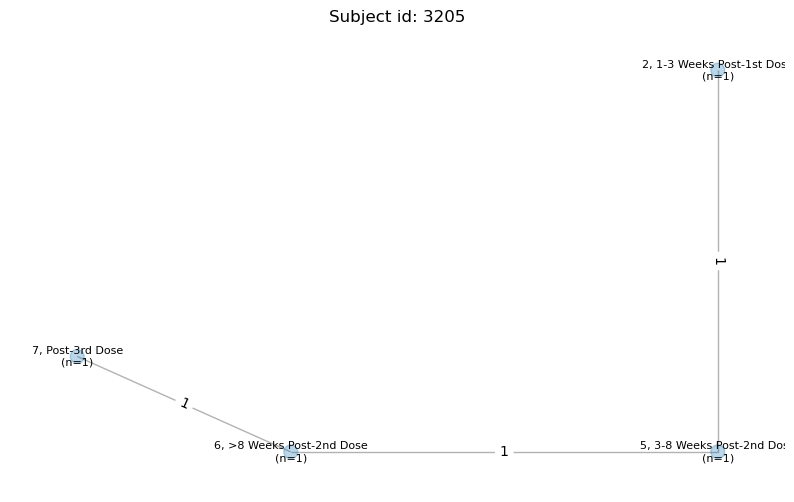

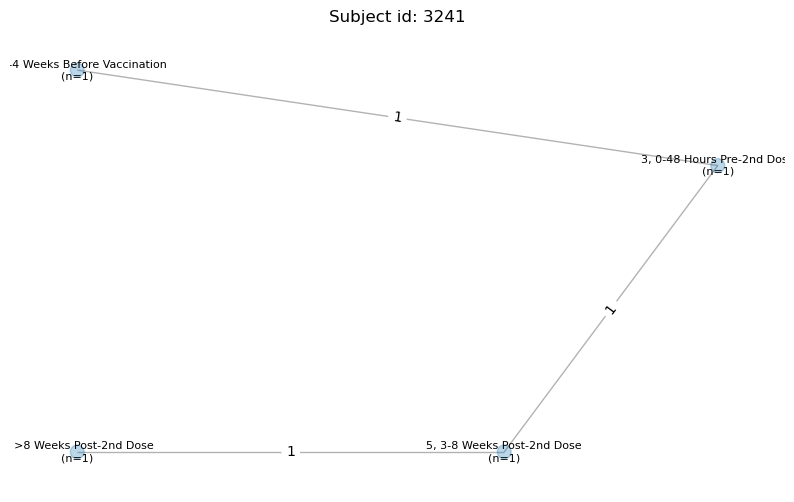

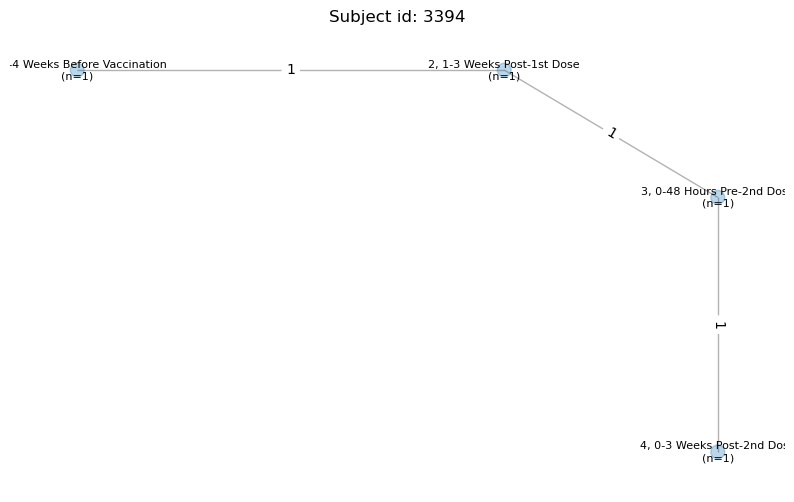

In [15]:
create_graph(repertoires, ['3205'], pos, 'Subject id: 3205')
create_graph(repertoires, ['3241'], pos, 'Subject id: 3241')
create_graph(repertoires, ['3394'], pos, 'Subject id: 3394')

# Neutralization

In [ ]:
# In all
high_count, low_count = 0, 0

for rep in repertoires['Repertoire']:
    if rep['sample'][0]['disease_state_sample'] == 'high':
        high_count += 1
    elif rep['sample'][0]['disease_state_sample'] == 'low':
        low_count += 1

print('High Count:', high_count)
print('Low Count: ', low_count)

High Count: 159
Low Count:  18


In [41]:
# By group
high_count, low_count = 0, 0

lo_hi_dict = {
    '1, 0-4 Weeks Before Vaccination' : [0, 0], 
    '3, 0-48 Hours Pre-2nd Dose' : [0, 0], 
    '5, 3-8 Weeks Post-2nd Dose' : [0, 0], 
    '4, 0-3 Weeks Post-2nd Dose' : [0, 0], 
    '6, >8 Weeks Post-2nd Dose' : [0, 0], 
    '7, Post-3rd Dose' : [0, 0], 
    '2, 1-3 Weeks Post-1st Dose' : [0, 0], 
    '99, ' : [0, 0]  
}


for rep in repertoires['Repertoire']:
    if rep['sample'][0]['disease_state_sample'] == 'high':
        lo_hi_dict[rep['sample'][0]['collection_time_point_reference']][1] += 1
    elif rep['sample'][0]['disease_state_sample'] == 'low':
        lo_hi_dict[rep['sample'][0]['collection_time_point_reference']][0] += 1

print('timepoint --- lo --- hi')
for key, value in lo_hi_dict.items():
    print(key, '---', str(value[0]), '---', str(value[1]))

timepoint --- lo --- hi
1, 0-4 Weeks Before Vaccination --- 8 --- 9
3, 0-48 Hours Pre-2nd Dose --- 2 --- 6
5, 3-8 Weeks Post-2nd Dose --- 0 --- 30
4, 0-3 Weeks Post-2nd Dose --- 0 --- 14
6, >8 Weeks Post-2nd Dose --- 7 --- 75
7, Post-3rd Dose --- 0 --- 19
2, 1-3 Weeks Post-1st Dose --- 1 --- 3
99,  --- 0 --- 3


In [56]:
def find_paired_timepoints(repertoires, tp1, tp2):
    '''
    Parameters
    ----------
    repertoires : dict
        - give this data: airr.read_airr('repertoires.airr.json')
    tp1 : str
        - timepoint 1
    tp2 : str
        - timepoint 2
    '''
    df = pd.DataFrame()

    for rep in repertoires['Repertoire']:
        if rep['subject']['subject_id'] in samp_multi_subj_id:
            new_df = pd.DataFrame({'id' : [rep['subject']['subject_id']], 
                                'timepoint' : [rep['sample'][0]['collection_time_point_reference']],
                                'neutralization' : [rep['sample'][0]['disease_state_sample']]})
            df = pd.concat([df, new_df], ignore_index=True)

    df = df.sort_values(by=['id', 'timepoint'], ignore_index=True)

    old_id = ''
    count = 0
    for i in range(len(df)):
        curr_id = df.loc[i, 'id']
        if old_id == curr_id:
            if tp1 == df.loc[i-1, 'timepoint'] and tp2 == df.loc[i, 'timepoint']:
                count += 1
        old_id = curr_id
    return count

In [57]:
find_paired_timepoints(repertoires, '5, 3-8 Weeks Post-2nd Dose', '6, >8 Weeks Post-2nd Dose')

4

In [60]:
def lo_hi_plot(dictionary):
    '''
    Parameters
    ----------
    dictionary : dict
        - A dictionary of timepoints and lo, hi neutralization counts
    '''
    sorted_items = sorted(lo_hi_dict.items(), key=lambda x: int(x[0].split(',')[0]))
    sorted_items.insert(1, sorted_items.pop())

    labels = [k for k, _ in sorted_items]
    low_vals = [v[0] for _, v in sorted_items]
    high_vals = [v[1] for _, v in sorted_items]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, low_vals, width, label='Low')
    bars2 = ax.bar(x + width/2, high_vals, width, label='High')

    ax.set_ylabel('Values')
    ax.set_title('Low vs High Counts per Timepoint')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

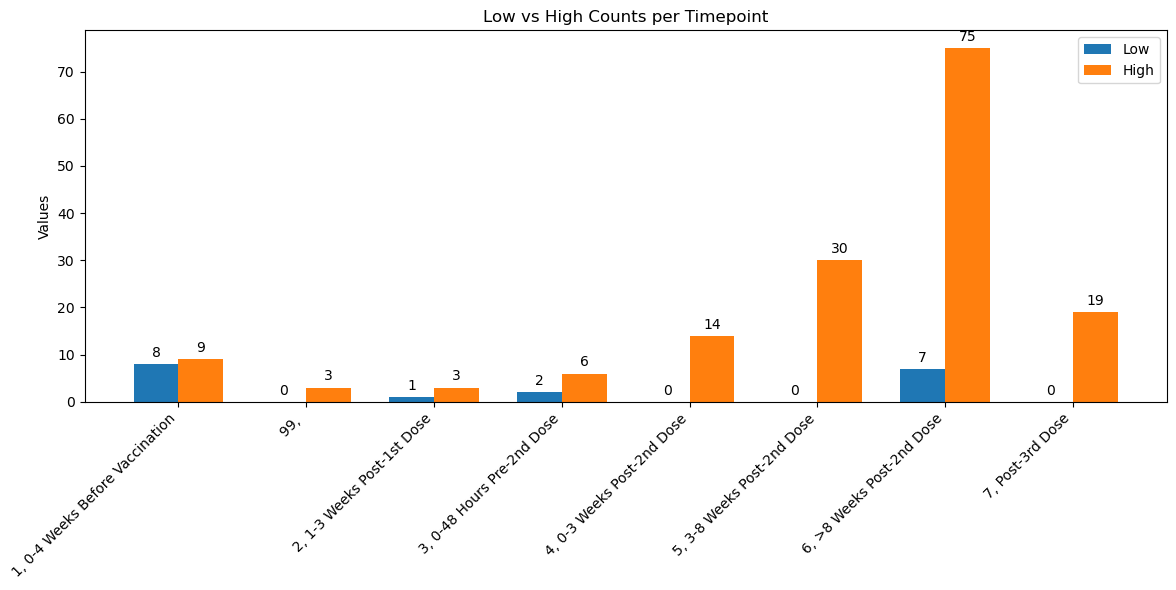

In [61]:
lo_hi_plot(lo_hi_dict)

In [ ]:
# df = pd.DataFrame({'test':['3', '2', '1', '99', '7', '5', '6', '4']})
# df.sort_values(by='test', ignore_index=True)

,test
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,99
